<a href="https://colab.research.google.com/github/1am-Fida/skripsi/blob/main/(arima%2C_es).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Install**

In [84]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import torch, numpy as np

# Kalau saya sukanya cek versi dan apakah PyTorch (atau tensorflow) sudah dapat mengakses GPU atau belum
print("Using Numpy and Pytorch versions = {}, {}".format(np.__version__, torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device, end=', ')
if device.type == 'cuda': #Additional Info when using cuda
    print(torch.cuda.get_device_name(0))
    print('Currently Memory Allocated, Cached =', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB, ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using Numpy and Pytorch versions = 1.22.4, 2.0.1+cu118
Using device: cuda, Tesla T4
Currently Memory Allocated, Cached = 0.0 GB,  0.0 GB


In [86]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
pip install dysts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
pip install nolds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **DATASET**

In [89]:
import warnings; warnings.simplefilter('ignore'); warnings.filterwarnings('ignore', module='darts'); warnings.filterwarnings('ignore', module='pandas')
import numpy as np, darts, sys, pandas as pd
from darts import metrics

In [90]:

import time

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    StatsForecastAutoARIMA,
    ARIMA,
    AutoARIMA,
    Theta,
    RegressionEnsembleModel,
    StatsForecastAutoETS)               # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<

from darts.metrics import smape, mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.utils.utils import ModelMode           # new

#from darts.datasets import (
#    AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset, HeartRateDataset,
#    IceCreamHeaterDataset, MonthlyMilkDataset, SunspotsDataset)


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)



TRACE = False                 # print also the suboptimal models while SARIMA tuning process is running
MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

In [91]:
from dysts.datasets import load_dataset

data = 'Lorenz84'
train_ = load_dataset(subsets="train", data_format="pandas", univariate=True).loc[data]
test_ = load_dataset(subsets="test", data_format="pandas", univariate=True).loc[data]


In [92]:
df = pd.concat([train_, test_], axis=0).reset_index()
# Hati-hati versi terbaru harus "reset_index" kalau ndak cell selanjutnya error
print(df.shape)
df.head(3)

(2000, 4)


,index,id,time,values
0,Lorenz84,64.0,0.000,0.335
1,Lorenz84,64.0,0.063,0.541
2,Lorenz84,64.0,0.125,0.775


In [93]:
df.drop(['index', 'id'], axis=1, inplace=True)

In [94]:
min_params = df[['time', 'values']].min()
max_params = df[['time', 'values']].max()

df[['time', 'values']] = (df[['time', 'values']] - min_params) / (max_params- min_params)

In [95]:
def df2series(df, cols):
    for i, col in enumerate(df[cols].columns):
        if i==0:
            series = darts.TimeSeries.from_dataframe(df, time_col=None, value_cols=col)
        else:
            series = series.stack(darts.TimeSeries.from_dataframe(df, time_col=None, value_cols=col))
    return series

cols = ['values'] # Silahkan rename jadi x, y, z


data = df2series(df, cols)
train, test = data.split_after(0.95)
print('Data train',len(train), '\nData test',len(test))

Data train 1900 
Data test 100


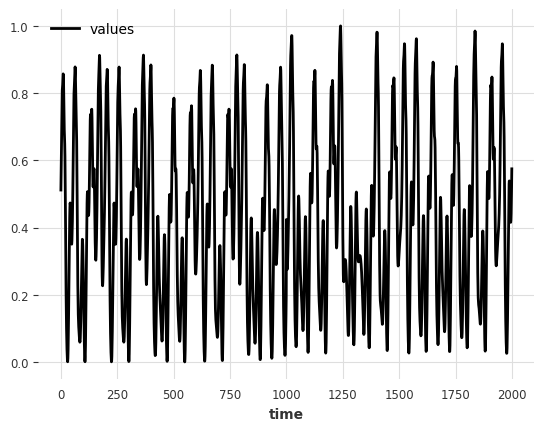

In [96]:
data.plot() # plot data aslinya

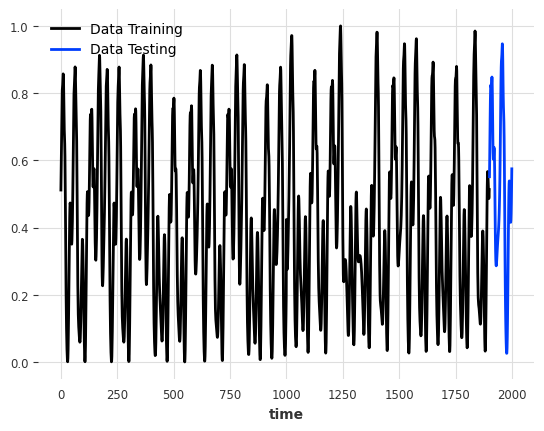

In [97]:
# plot data split train_test
train.plot(label = 'Data Training')
test.plot(label = 'Data Testing')

In [98]:
df.describe()

,time,values
count,2000.000,2000.000
mean,0.500,0.425
std,0.289,0.259
min,0.000,0.000
25%,0.250,0.211
50%,0.500,0.405
75%,0.750,0.625
max,1.000,1.000


In [99]:
import nolds

sample = nolds.sampen(df['values'])
DFA = nolds.dfa(df['values'])
lyapunov = nolds.lyap_r(df['values'].iloc[:],emb_dim= 3)
lyapunov_e = nolds.lyap_e(df['values'].iloc[:], emb_dim=3,matrix_dim=3)
correlation = nolds.corr_dim(df['values'].iloc[:], 3)

In [100]:
print("sampen : ",sample)
print("DFA : ",DFA)
print("lyapunov : ",lyapunov)
print("spektrum lyapunov_eksponen : ",lyapunov_e)
print("correlation : ",correlation)

sampen :  0.47200056313679184
DFA :  1.2999716435680029
lyapunov :  -0.005276235125281584
spektrum lyapunov_eksponen :  [ 0.2409448  -0.01262146 -0.33838376]
correlation :  1.694884447029508


In [101]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(data, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? False


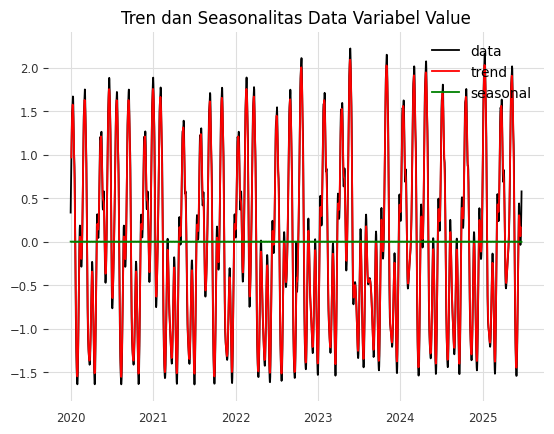

In [127]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

series_x = list(pd.concat([train_['values'], test_['values']], ignore_index=True))
date_rng = pd.date_range(start='1/1/2020', periods=2000)
series_x = pd.DataFrame(series_x, index=date_rng)
decomposition = sm.tsa.seasonal_decompose(series_x, model='additive')

plt.title('Tren dan Seasonalitas Data Variabel Value')
plt.plot(series_x, label='data')
plt.plot(decomposition.trend, color='red', label='trend')
plt.plot(decomposition.seasonal, color='green', label='seasonal')
plt.legend(loc='upper right')
plt.show()

In [102]:
# compute accuracy metrics and processing time

def accuracy_metrics(act, forecast, resid, t_start):
    sr = resid.pd_series()
    sa = act.pd_series()
    n_act = len(act)
    res_mape = mape(act, forecast)
    res_smape = smape(act, forecast)
    res_mae = mae(act, forecast)
    res_r2 = r2_score(act, forecast)
    res_rmse = rmse(act, forecast)
    res_rmsle = rmsle(act, forecast)
    res_pe = sr / sa
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error

    res_time = time.perf_counter() - t_start

    res_mean = np.mean(sr)
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast

    res_accuracy = {"SMAPE" : res_smape,"MAPE":res_mape,"RMSE":res_rmse, "-R squared":-res_r2,
        "se": res_sefc, "time":res_time}
    return res_accuracy

In [62]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    strmodel = str(model)[:30]
    print("beginning: " + strmodel)


    # fit the model and compute predictions
    n_val = len(test)
    res = model.fit(train)
    forecast = model.predict(n_val)


    # for naive forecast, concatenate seasonal fc with drift fc
    ##if model == m_stat:
    ##    if is_seasonal:
    ##        fc_drift = forecast
      ##      modelS = NaiveSeasonal(K=mseas)
       ##     modelS.fit(train)
         #### forecast = fc_drift + fc_seas - train.last_value()


    resid = forecast - test
    res_accuracy = accuracy_metrics(test, forecast, resid, t_start)


    results = [forecast, res_accuracy]

    print("completed: " + strmodel + ":" + str(res_accuracy["time"]) + " sec")
    return results

### **Model**

**ARIMA**

In [63]:
# prepare stat-forecast-auto-arima forecaster

m_arima = ARIMA(
            p =2, d = 1, q = 3, trend = 'n'
            )

#seasonal_order (Tuple[int, int, int, int]) – The (P,D,Q,s) order of the seasonal component for the AR parameters, differences, MA parameters and periodicity.



print("model:", m_arima)

model: ARIMA(p=2, q=3, trend=n)


**Exponential Smoothing**

In [64]:
m_expo = ExponentialSmoothing(
      trend= ModelMode.ADDITIVE,
      damped= False,
      seasonal= ModelMode.ADDITIVE,
      seasonal_periods= None,
      random_state=0
)

print("model:", m_expo)

model: ExponentialSmoothing(seasonal=ModelMode.ADDITIVE)


###**Evaluasi**

In [65]:
# laundry list of forecasters to run

models = [
    m_arima,
    m_expo]


In [66]:
# call the forecasters one after the other
model_predictions = [eval_model(model) for model in models]

beginning: ARIMA(p=2, q=3, trend=n)
completed: ARIMA(p=2, q=3, trend=n):1.39233673800004 sec
beginning: ExponentialSmoothing(seasonal=
completed: ExponentialSmoothing(seasonal=:0.4742980409999973 sec


In [67]:
# RUN the forecasters and tabulate their prediction accuracy and processing time

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0:
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        #col_head = ["ARIMA", "Exponential Smoothing"]
        #df.columns = col_head
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,"ARIMA(p=2, q=3, trend=n)",ExponentialSmoothing(seasonal=ModelMode.ADDITIVE)
SMAPE,46.084519,96.473351
MAPE,158.837401,610.924277
RMSE,0.279974,1.308531
-R squared,0.322570,27.890206
se,0.493516,0.867579
time,1.392337,0.474298


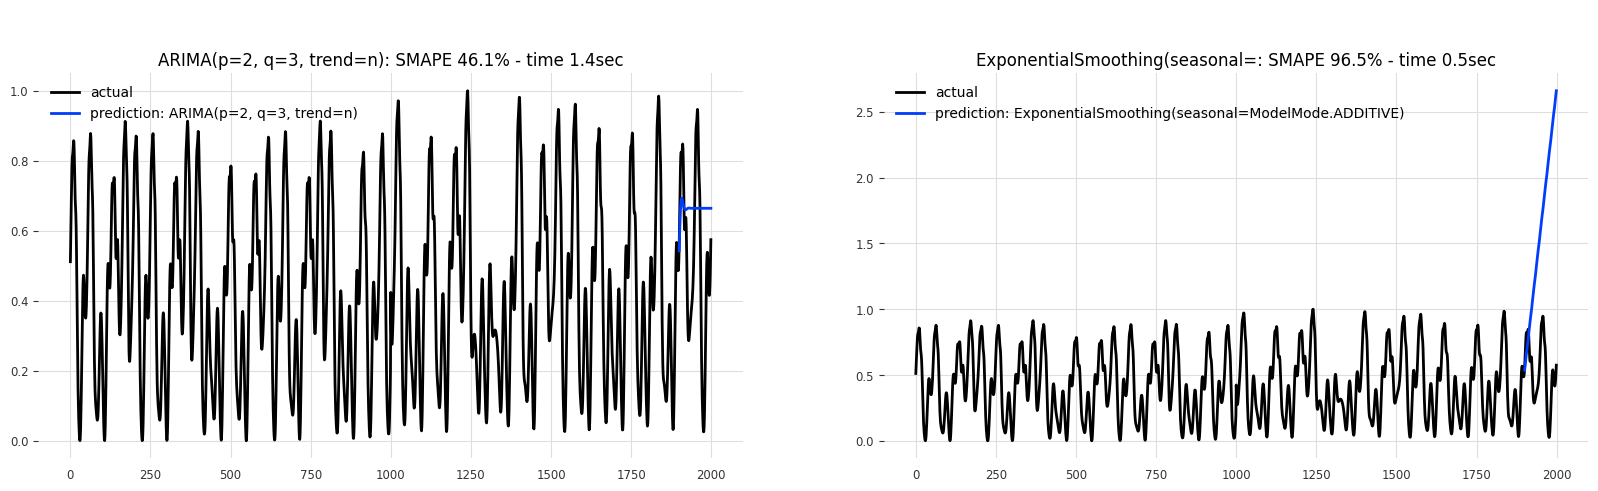

In [68]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        data.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])

        mape_model =  model_predictions[i][1]["SMAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m)[:30] + ": SMAPE {:.1f}%".format(mape_model) + " - time {:.1f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()


In [69]:
act = test

resL = {}
resN = {}
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series()

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]


print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
_ = [print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
_ = [print(key,":",value) for key,value in resN.items()]




Ljung-Box test for white-noise residuals: p-value > alpha?
ARIMA(p=2, q=3, trend=n) : 6.480228281259373e-84
ExponentialSmoothing(seasonal=ModelMode.ADDITIVE) : 1.620592509547097e-93

test for normality of residuals: p-value > alpha?
ARIMA(p=2, q=3, trend=n) : 0.05382197062063062
ExponentialSmoothing(seasonal=ModelMode.ADDITIVE) : 1.943952101931237e-06


### **Ensemble Model**

In [103]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    t_start =  time.perf_counter()
    n_train = 50                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[    ARIMA(p = 2, d= 1, q=3),
                                                        ExponentialSmoothing(
                                                                            trend=None,#ModelMode.ADDITIVE,
                                                                            damped=False,
                                                                            seasonal=ModelMode.ADDITIVE,
                                                                            seasonal_periods=None
                                                                             )],
                                regression_train_n_points=12)



    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid, t_start)


    # plot the ensemble forecast
    data.plot(label="actual")
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


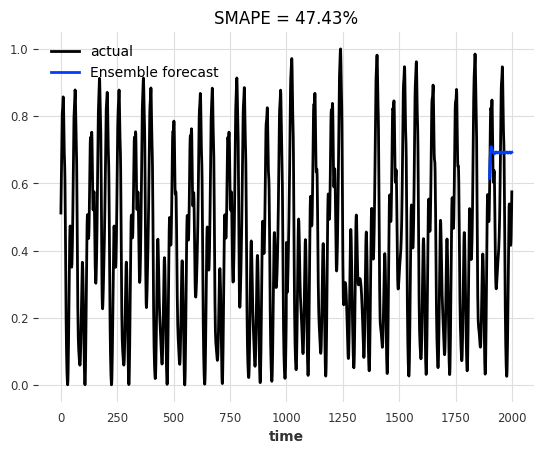

In [104]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


In [105]:
# collect the accuracy metrics

df_acc2 = df_acc.copy()
df_acc2["avg"] = df_acc2.mean(axis=1)
df_acc2["Ensemble"] = pd.Series(res_ensemble[1])
df_acc2.columns = col_heads
df_acc2.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,ARIMA,Exponential Smoothing,avg,Ensemble
SMAPE,46.084519,96.473351,71.278935,47.430559
MAPE,158.837401,610.924277,384.880839,167.305484
RMSE,0.279974,1.308531,0.794252,0.294861
-R squared,0.322570,27.890206,14.106388,0.466962
se,0.493516,0.867579,0.680548,0.493527
time,1.392337,0.474298,0.933317,8.093976


In [106]:
#resid = res_ensemble[2]

resid = res_ensemble[0] - test
sr = resid.pd_series()
#plot_residuals_analysis(resid);
#plt.title("Ensemble forecast")

In [107]:
resL = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
resN = normaltest(sr)[1]

print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
print(resL)

print("\ntest for normality of residuals: p-value > alpha?")
print(resN)


Ljung-Box test for white-noise residuals: p-value > alpha?
5.653574770311199e-84

test for normality of residuals: p-value > alpha?
0.066835337334527


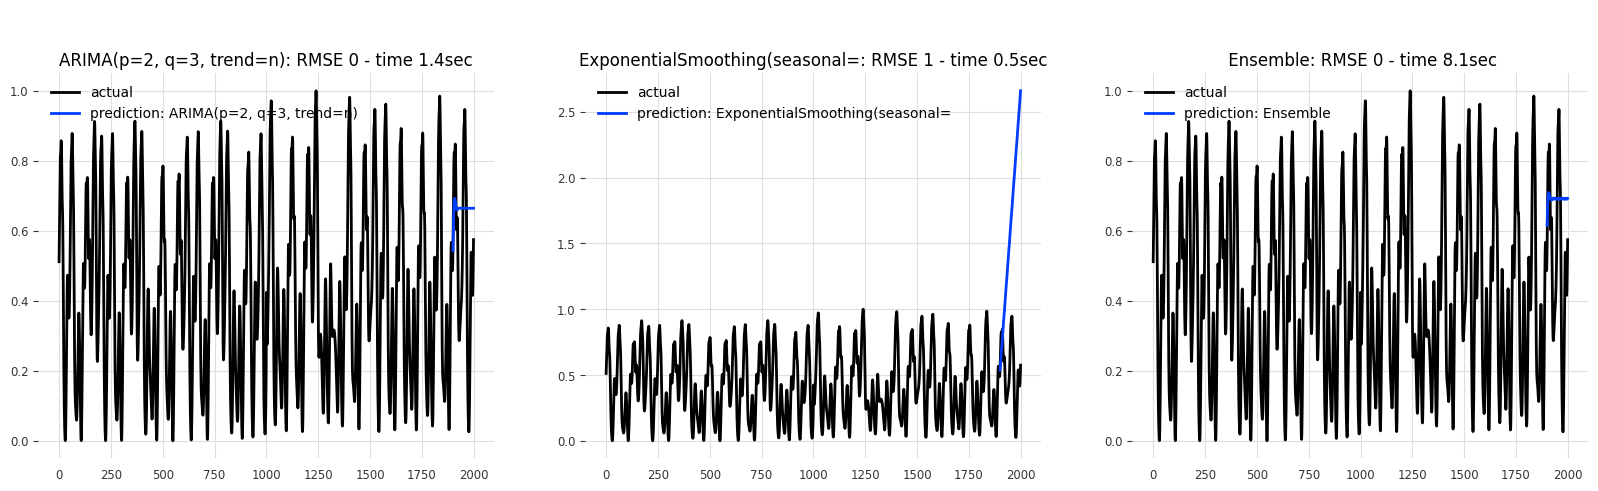

In [108]:
# plot the forecast scenario, and now include the ensemble

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 3, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        data.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m)[:30], ax=ax[i])
        rmse_model =  model_predictions[i][1]["RMSE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m)[:30] + ": RMSE {:.0f}".format(rmse_model) + " - time {:.1f}sec".format(time_model))
        ax[i].set_xlabel("")
        ax[i].legend()


# add the ensemble:
data.plot(label="actual", ax=ax[i+1])
res_ensemble[0].plot(label="prediction: Ensemble", ax=ax[i+1])
rmse_model =  res_ensemble[1]["RMSE"]
time_model =  res_ensemble[1]["time"]
ax[i+1].set_title("\n\n Ensemble: RMSE {:.0f}".format(rmse_model) + " - time {:.1f}sec".format(time_model))
ax[i+1].set_xlabel("")
ax[i+1].legend();


### **Longterm Forecasting Analysis**

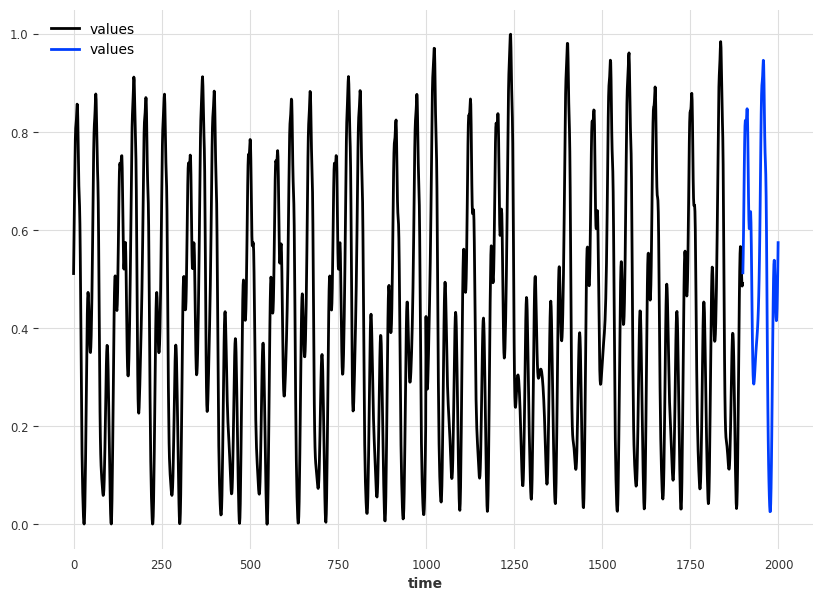

In [109]:
train, test = data.split_before(0.95)
plt.figure(figsize=(10,7))
train.plot()
test.plot()

In [110]:
ensemble_model_ = RegressionEnsembleModel(
                                forecasting_models=[    ARIMA(p = 2, d= 1, q=3),
                                                        ExponentialSmoothing(
                                                                            trend=ModelMode.ADDITIVE,
                                                                            damped=False,
                                                                            seasonal=ModelMode.ADDITIVE,
                                                                            seasonal_periods=None)],
                                regression_train_n_points=12)

ensemble_model_.fit(train)

RegressionEnsembleModel(regression_model=None, forecasting_models=[ARIMA(p=2, d=1, q=3, seasonal_order=(0, 0, 0, 0), trend=None, random_state=0, add_encoders=None), ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=None, random_state=0)], regression_train_n_points=12)

**MAPE**

In [111]:
error = []

for i in range(1,11):
  percent = i/200
  forecast = ensemble_model_.predict(int(percent*len(data)))
  if i == 10:
    mape = darts.metrics.mape(test, forecast)
  else:
    mape = darts.metrics.mape(test[:len(forecast)], forecast)
  error.append(mape)
  print("Prediksi test dengan {}% langkah, MAPE={} ".format(i, mape), flush=True)

Prediksi test dengan 1% langkah, MAPE=12.426672934646103 
Prediksi test dengan 2% langkah, MAPE=12.65604034127928 
Prediksi test dengan 3% langkah, MAPE=20.66709826172514 
Prediksi test dengan 4% langkah, MAPE=40.39205967914878 
Prediksi test dengan 5% langkah, MAPE=39.74306667883766 
Prediksi test dengan 6% langkah, MAPE=37.68600612130323 
Prediksi test dengan 7% langkah, MAPE=35.313629807544686 
Prediksi test dengan 8% langkah, MAPE=156.85561995871882 
Prediksi test dengan 9% langkah, MAPE=158.9839904082252 
Prediksi test dengan 10% langkah, MAPE=146.35589904236474 


In [112]:
#round(1.527, 2)
mape_bulat =[]

for i in range(len(error)):
    bulat_ = round(error[i],2)
    mape_bulat.append(bulat_)
mape_bulat

[12.43, 12.66, 20.67, 40.39, 39.74, 37.69, 35.31, 156.86, 158.98, 146.36]

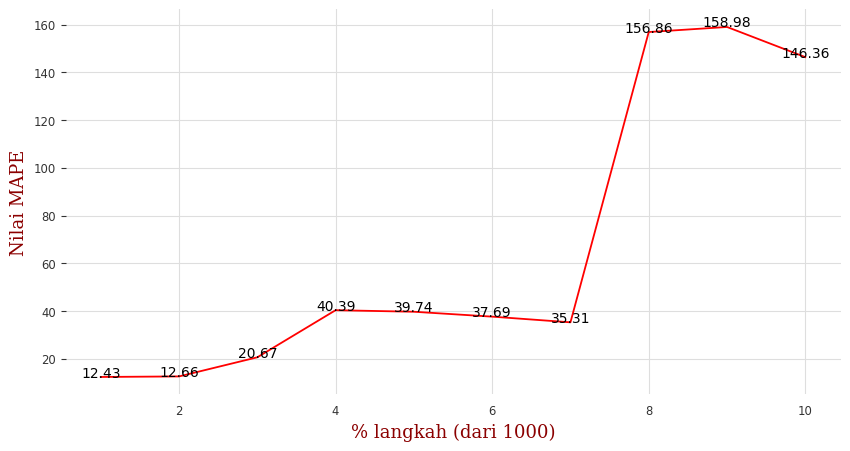

In [113]:
x=list(range(1,11))

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }

def addlabels(x,y):
    for i in range(1,11):
        plt.text(i, y[i-1], y[i-1], ha = 'center')

plt.figure(figsize = (10, 5))
plt.plot(x, mape_bulat, color = 'red') #error
addlabels(x, mape_bulat)
#plt.title('Grafik nilai MAPE tiap % langkah', fontdict=font)
plt.xlabel('% langkah (dari 1000)', fontdict=font)
plt.ylabel('Nilai MAPE', fontdict=font)

# Tweak spacing to prevent clipping of ylabel
plt.show()

**SMAPE**

In [114]:
error_smape = []

for i in range(1,11):
  percent = i/200
  forecast = ensemble_model_.predict(int(percent*len(data)))
  if i == 10:
    smape = darts.metrics.smape(test, forecast)
  else:
    smape = darts.metrics.smape(test[:len(forecast)], forecast)
  error_smape.append(smape)
  print("Prediksi test dengan {}% langkah, SMAPE={} ".format(i, smape), flush=True)

Prediksi test dengan 1% langkah, SMAPE=13.430718643746111 
Prediksi test dengan 2% langkah, SMAPE=13.709216386669402 
Prediksi test dengan 3% langkah, SMAPE=18.072590357092945 
Prediksi test dengan 4% langkah, SMAPE=30.04044215951523 
Prediksi test dengan 5% langkah, SMAPE=30.007426309952344 
Prediksi test dengan 6% langkah, SMAPE=30.35444476040068 
Prediksi test dengan 7% langkah, SMAPE=29.050384779340543 
Prediksi test dengan 8% langkah, SMAPE=43.47545375969186 
Prediksi test dengan 9% langkah, SMAPE=46.074407919363914 
Prediksi test dengan 10% langkah, SMAPE=44.23890293696168 


In [115]:
smape_bulat =[]

for i in range(len(error_smape)):
    bulat_ = round(error_smape[i],2)
    smape_bulat.append(bulat_)
smape_bulat

[13.43, 13.71, 18.07, 30.04, 30.01, 30.35, 29.05, 43.48, 46.07, 44.24]

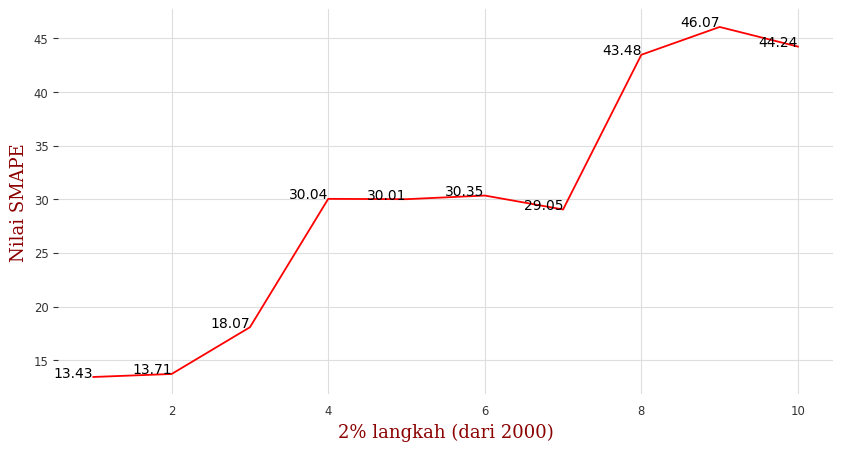

In [116]:
x=list(range(1,11))

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }

def addlabels(x,y):
    for i in range(1,11):
        plt.text(i, y[i-1], y[i-1], ha = 'right')

plt.figure(figsize = (10, 5))
plt.plot(x, smape_bulat, color = 'red') #error
addlabels(x, smape_bulat)
#plt.title('Grafik nilai MAPE tiap % langkah', fontdict=font)
plt.xlabel('2% langkah (dari 2000)', fontdict=font)
plt.ylabel('Nilai SMAPE', fontdict=font)

# Tweak spacing to prevent clipping of ylabel
plt.show()